# Progress report 2

*Asura Enkhbayar, 15.06.2020*

This report contains a brief summary of the methodology and a few descriptives to assess it. Furthermore, some statistics and plots are generated for the citationa and altmetrics gathered for the current data.

In [99]:
from pathlib import Path

from IPython.display import Markdown as md

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn3
import pandas as pd
import seaborn as sns

import numpy as np

from tracking_grants import references_f, articles_f, wos_f, altmetric_f

In [2]:
# Seaborn styles
sns.set_style("darkgrid")

# Matplotlib figure configuration fonts and figsizes
plt.rcParams.update({
    'font.family':'sans-serif',
    'font.size': 16.0,
    'text.usetex': False,
    'figure.figsize': (11.69,8.27)
})

# Color palette
cm = "Paired"
cp3 = sns.color_palette(cm, 3)
cp10 = sns.color_palette(cm, 10)

## Methodology

### 1. Input data

The input data always comes from the CDMRP database (https://cdmrp.army.mil/search.aspx). The data contains unstructured references and grant IDs for each article in the selected research program.

In [3]:
# Load references
refs = pd.read_csv(references_f, index_col="reference_id")

In [4]:
keywords = refs.type.unique().tolist()
mds = f"""
**Data from CDMRP database**

- Selected research programs: { ", ".join(keywords) }
- Total number of references found: { len(refs) }
- Unique references: { refs.reference.nunique() } => Several articles are in multiple research programs and multiple grants affiliated
    - Unique grant IDs: { refs.grant_id.nunique() }
"""
md(mds)


**Data from CDMRP database**

- Selected research programs: TSCRP, NFRP, PCRP, PRORP
- Total number of references found: 9078
- Unique references: 8620 => Several articles are in multiple research programs and multiple grants affiliated
    - Unique grant IDs: 2227


### 2. Matching references to articles

From here on, we are using a [reference matcher](https://gitlab.com/crossref/search_based_reference_matcher) developed by Dominika Tkaczyk at Crossref. The algorithm is described to some degree in a blog series: https://www.crossref.org/blog/matchmaker-matchmaker-make-me-a-match/

The algorithm is implemented in Java and no longer very well maintained. However, it seems to be working fine. Dominika recommends up to 20 threads (already implemented) and with some workarounds we could also implement progress reports for larger datasets which are not supported at the moment.

In our case, I used the 8620 unique references from our dataset and matched 6711 articles. Each matched article also comes with the matching score. In this case, the implementation takes care of thresholds and simply returns Nulls for those references that are not matching (enough).

In [5]:
# Load matched articles
articles = pd.read_csv(articles_f, index_col="DOI")

articles.index = articles.index.str.lower()

In [6]:
x = articles[['reference']].merge(refs, left_on="reference", right_on="reference")

mds = f"""
**Matching references with Crossref**

- Matched articles: { len(articles) }
- Articles in multiple research programs: { (x.groupby("reference").type.nunique()>1).sum() }
- Articles funded by multiple grants: { (x.groupby("reference").grant_id.nunique()>1).sum() }
"""
md(mds)


**Matching references with Crossref**

- Matched articles: 6711
- Articles in multiple research programs: 197
- Articles funded by multiple grants: 172


### 3. Retrieving metrics

Once the the references have been matched to articles in Crossref, we are using the DOIs to retrieve metrics from the Web of Science and Altmetric.

In [7]:
# Load metrics from WoS
wos = pd.read_csv(wos_f,  low_memory=False, index_col="DOI")
wos.columns = [x.lower() for x in wos.columns.tolist()]
wos.index = wos.index.str.lower()

wos = wos.rename(columns={'relative citation score':'citation_score'})

In [8]:
# Load metrics from Altmetric
altmetrics = pd.read_json(altmetric_f).T

# Filter out all articles had not altmetrics
altmetrics = altmetrics[altmetrics.altmetric_id.notna()]

In [9]:
dates = ["last_updated", "published_on", "added_on"]
for d in dates:
    altmetrics[d] = pd.to_datetime(altmetrics[d], unit="s")

str_cols = ["pmid", "pmc", "altmetric_id", "doi", 'hollis_id', "arxiv_id"]
for _ in str_cols:
    altmetrics[_] = altmetrics[_].astype(str)
    
metric_cols = {
    'cited_by_posts_count': 'posts_count',
    'cited_by_rh_count': 'research_highlight',
    'cited_by_tweeters_count': 'twitter_accounts',
    'cited_by_patents_count': 'patents',
    'cited_by_msm_count': 'news_outlets',
    'cited_by_feeds_count': 'blogs',
    'cited_by_fbwalls_count': 'fb_pages',
    'cited_by_qna_count': 'qna_count',
    'cited_by_videos_count': 'videos',
    'cited_by_peer_review_sites_count': 'peer_reviews',
    'cited_by_weibo_count': 'weibo',
    'cited_by_gplus_count': 'gplus',
    'cited_by_rdts_count': 'reddit_threads',
    'cited_by_policies_count': 'policies',
    'cited_by_syllabi_count': 'syllabi',
    'cited_by_linkedin_count': 'linkedin',
    'cited_by_wikipedia_count': 'wikipedia',
}
altmetrics = altmetrics.rename(columns=metric_cols)
metric_cols = list(metric_cols.values())

altmetrics[metric_cols] = altmetrics[metric_cols].astype(float)

cols_to_keep = metric_cols + dates + str_cols + ['subjects', 'scopus_subjects']
altmetrics = altmetrics[cols_to_keep]

# Transform all DOIs to lowercase
altmetrics.index = altmetrics.index.str.lower()

## Results in detail

In [10]:
metrics = articles[[]].merge(altmetrics[metric_cols], left_index=True, right_index=True, how="left")
metrics = metrics.merge(wos[["citations", "citation_score"]], left_index=True, right_index=True, how="left")

In [11]:
# Replace articles with 0 citations as NaN
metrics = metrics.replace(0.0, np.nan)

In [12]:
mds = f"""
**Metrics from the Web of Science and Altmetric.com**

- Articles found in WoS: { len(wos) }
    - Articles with at least 1 citation: { metrics.citations.count() }
- Articles found in Altmetric.com: { len(altmetrics) }
    - Articles with tweets: { altmetrics.twitter_accounts.notna().sum() }
    - Articles with FB mentions: { altmetrics.fb_pages.notna().sum() }
"""
md(mds)


**Metrics from the Web of Science and Altmetric.com**

- Articles found in WoS: 2688
    - Articles with at least 1 citation: 2610
- Articles found in Altmetric.com: 3372
    - Articles with tweets: 1488
    - Articles with FB mentions: 432


### Coverage

In [13]:
all_articles = set(articles.index.tolist())
articles_w_altm = set(altmetrics.index.tolist())
articles_w_cit = set(wos.index.tolist())

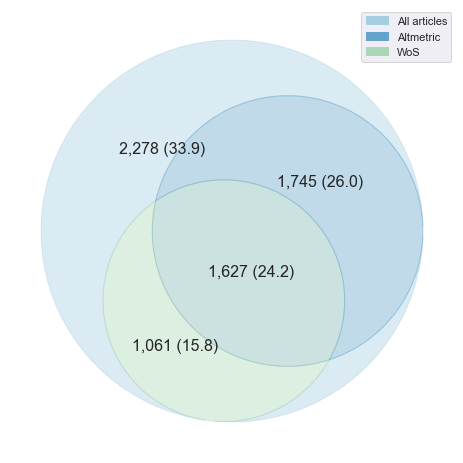

In [14]:
total = len(all_articles)

v = venn3([all_articles, articles_w_altm, articles_w_cit],
      set_labels=('', '', ''),
      subset_label_formatter=lambda x: "{:,} ({:.1f})".format(x, 100*x/total));

v.get_patch_by_id('100').set_color(cp3[0])
v.get_patch_by_id('110').set_color(np.add(cp3[0], cp3[1])/2)
v.get_patch_by_id('101').set_color(np.add(cp3[0], cp3[2])/2)
v.get_patch_by_id('111').set_color(np.add(np.add(cp3[1], cp3[0]), cp3[2]) / 3)

for text in v.set_labels:
    text.set_fontsize(10)
# for text in v.subset_labels:
#     text.set_fontsize(12)

handles = []
labels=["All articles", "Altmetric", "WoS"]
for l, c in zip(labels, [cp3[0], np.add(cp3[0], cp3[1])/2, np.add(cp3[0], cp3[2])/2]):
    handles.append(mpatches.Patch(color=c, label=l))
plt.legend(handles=handles);

# plt.gca().legend(handles=[v.get_patch_by_id('100'), v.get_patch_by_id('010'), v.get_patch_by_id('001')],
#                  , prop={'size': 12});

#### Disciplines

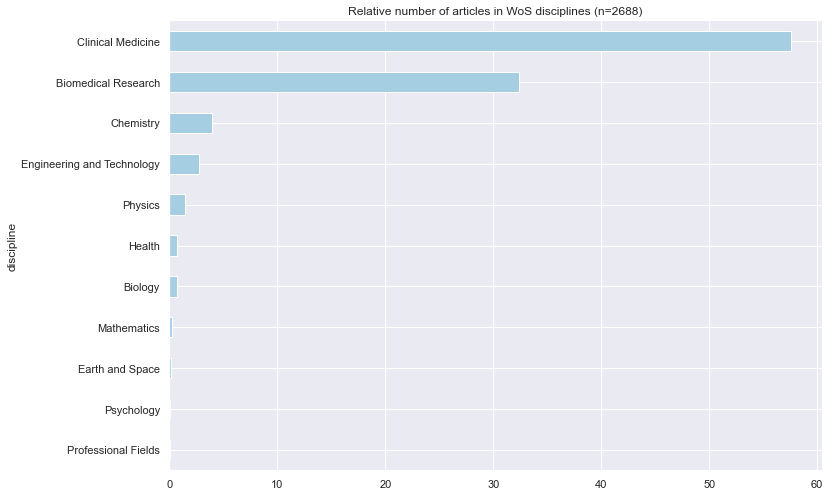

In [15]:
wos.groupby("discipline").size().div(len(wos)/100).sort_values().plot(kind="barh", color=cp3[0])
plt.title(f"Relative number of articles in WoS disciplines (n={len(wos)})")
sns.despine()

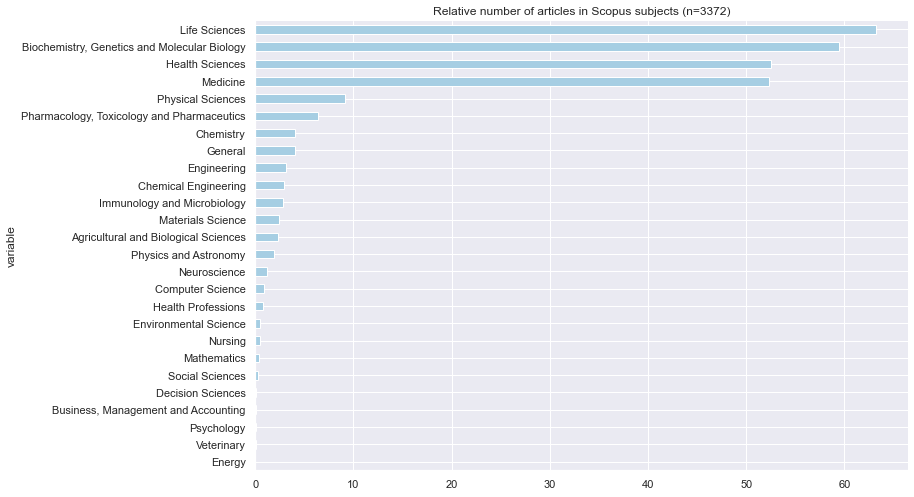

In [16]:
pdf = pd.get_dummies(altmetrics['scopus_subjects'].apply(pd.Series).stack()).sum(level=0).melt()
pdf.groupby("variable")['value'].sum().div(len(altmetrics)/100).sort_values().plot(kind="barh", color=cp3[0])
plt.title(f"Relative number of articles in Scopus subjects (n={len(altmetrics)})")
sns.despine()

### Counts

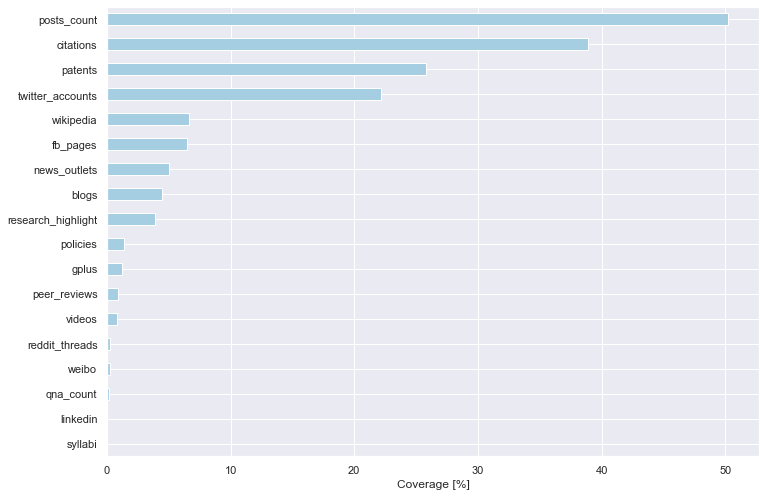

In [17]:
pdf = metrics[metrics.columns.drop('citation_score')].count().div(len(metrics)/100).sort_values()
pdf.plot(kind="barh", color=cp3[0])
plt.xlabel("Coverage [%]")
count_order = pdf.index.tolist()

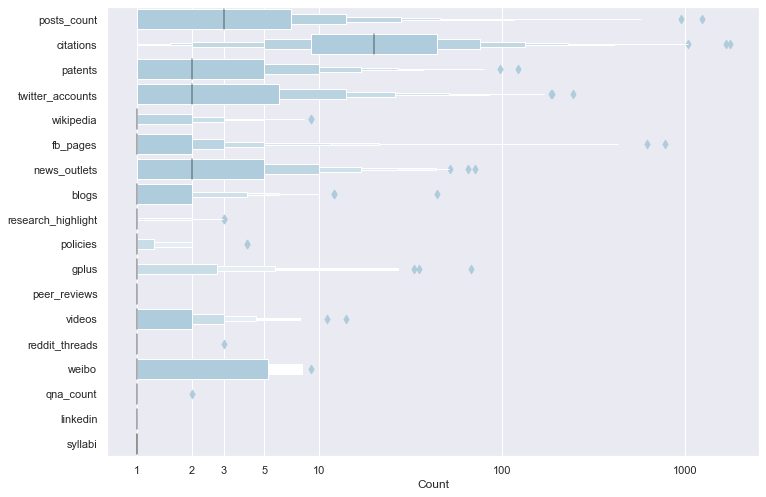

In [18]:
pdf = metrics[metrics.columns].reset_index().melt(id_vars="DOI")
sns.boxenplot(y="variable", x="value", data=pdf, order=count_order[::-1], k_depth="trustworthy", color=cp3[0])
plt.ylabel("")
plt.xlabel("Count")
plt.xscale("log")
ticks = [1,2,3,5,10,100,1000]
plt.xticks(ticks, ticks);

In [19]:
wos.groupby("discipline").citation_score.mean().to_frame("avg_citation_score")

,avg_citation_score
discipline,
Biology,2.366737
Biomedical Research,2.236923
Chemistry,1.434047
Clinical Medicine,2.030200
Earth and Space,0.982333
Engineering and Technology,2.124703
Health,0.787700
Mathematics,1.490500
Physics,1.435974


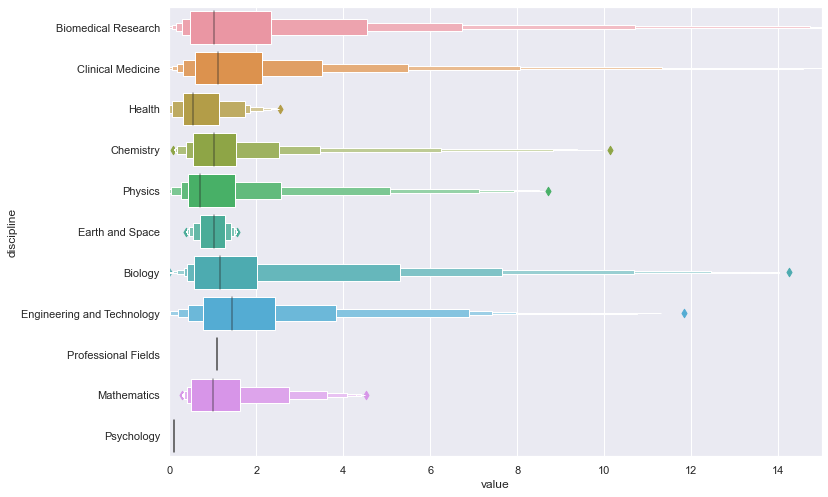

In [20]:
pdf = wos.melt(id_vars="discipline", value_vars="citation_score")
sns.boxenplot(y="discipline", x="value", data=pdf)
plt.xlim(0,15);

### Web of Science in detail

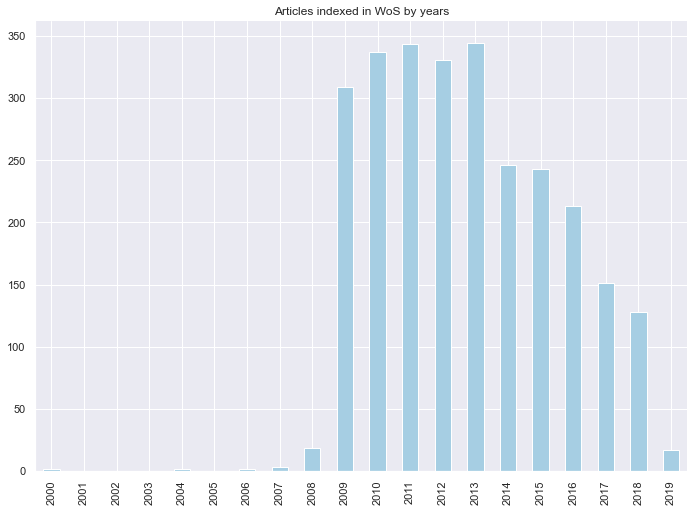

In [21]:
pdf = pd.DataFrame(index=range(2000,2020))
pdf['count'] = wos.groupby("year").size()
pdf['count'].plot(kind="bar", color=cp3[0]);
sns.despine()
plt.title("Articles indexed in WoS by years");

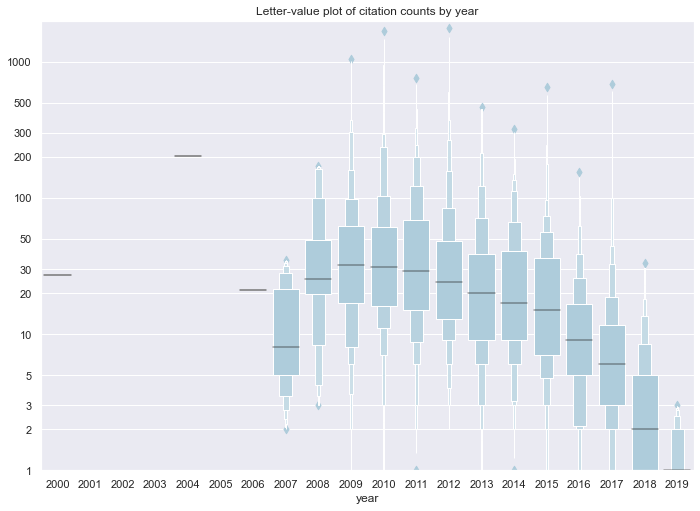

In [22]:
pdf = wos.replace(0, np.nan).melt(id_vars="year", value_vars="citations")
for y in range(pdf.year.min(),pdf.year.max()+1):
    if str(y) not in pdf.year:
        pdf.loc[len(pdf)+1] = [y, 'citations', np.nan]
sns.boxenplot(x="year", y="value", data=pdf, color=cp3[0])
plt.title("Letter-value plot of citation counts by year")
plt.ylim(1,2000)
plt.yscale("log")
plt.ylabel("")
ticks = [1,2,3,5,10,20,30,50,100,200,300,500,1000]
plt.yticks(ticks, ticks);

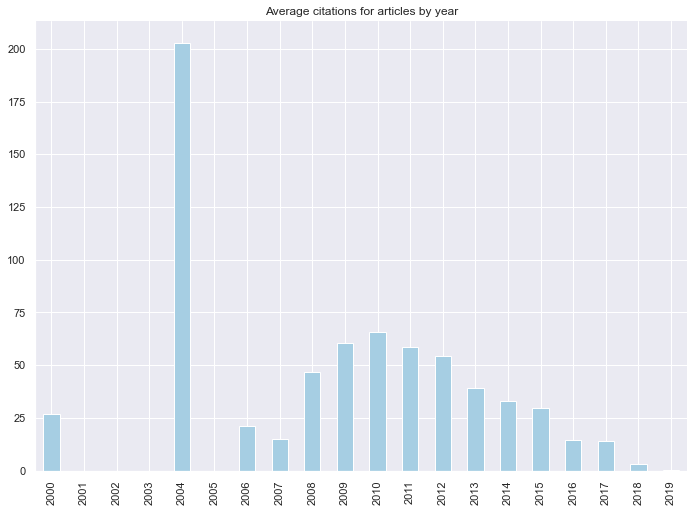

In [23]:
pdf = pd.DataFrame(index=range(2000,2020))
pdf['mean'] = wos.groupby("year").citations.mean()
pdf['mean'].plot(kind="bar", color=cp3[0])
sns.despine()
plt.title("Average citations for articles by year");

#### Altmetrics in detail

In [24]:
altmetrics['year'] = altmetrics.published_on.map(lambda x: str(x.year))

In [25]:
pdf = altmetrics.groupby("year").size().to_frame("count")
pdf.index = pdf.index.astype(float)
for y in range(int(pdf.index.min()), int(pdf.index.max()+1)):
    if y not in pdf.index:
        pdf.loc[y] = [np.nan]

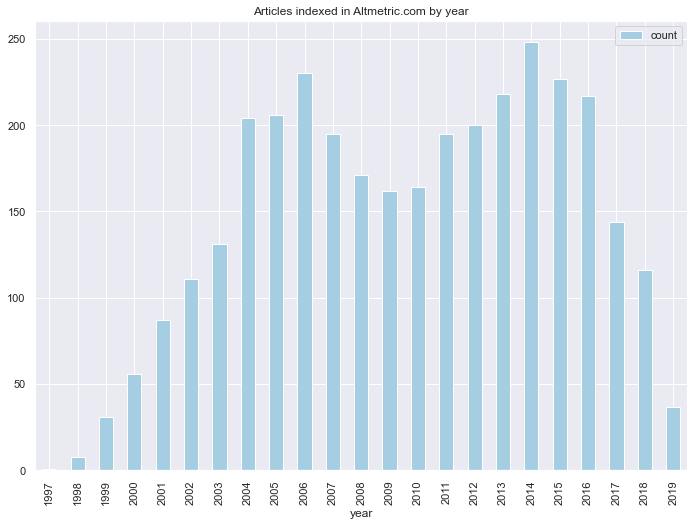

In [26]:
pdf = altmetrics.groupby("year").size().to_frame("count")
pdf = pdf[pdf.index.astype(float)>1996]
pdf.plot(kind="bar", color=cp3[0]);
plt.title("Articles indexed in Altmetric.com by year");

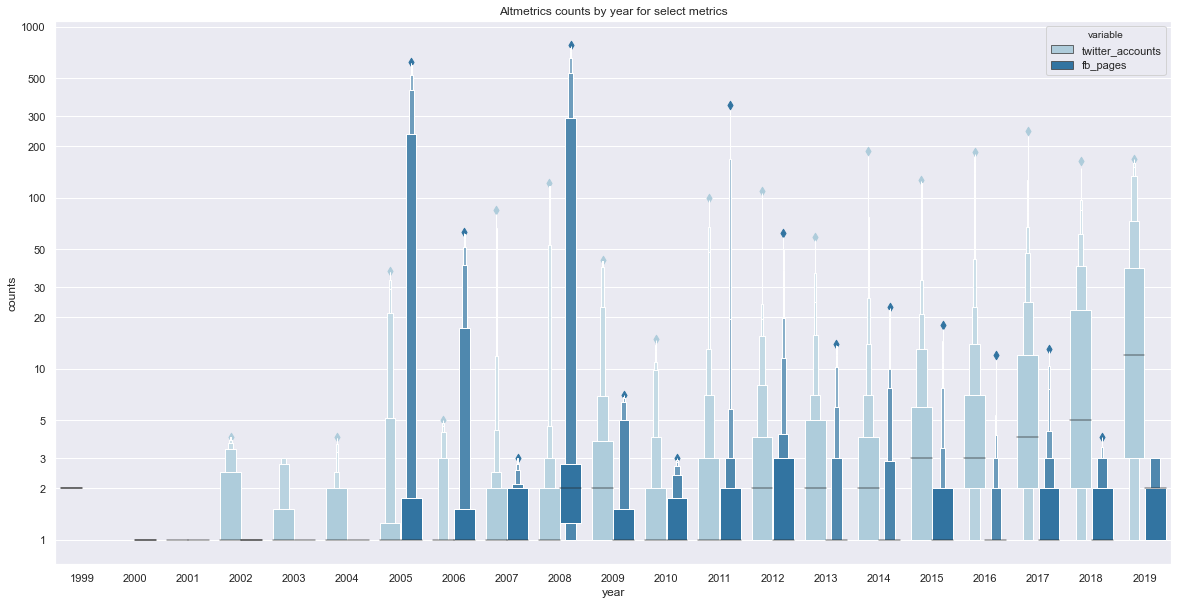

In [27]:
plt_metrics = ['twitter_accounts', 'fb_pages']
pdf = altmetrics.melt(id_vars="year", value_vars=plt_metrics, value_name="counts")
pdf = pdf[pdf.year.astype(float)>1996]
pdf = pdf.dropna()

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.boxenplot(x="year", y="counts", hue="variable", data=pdf, ax=ax, palette="Paired")
plt.yscale("log")
ticks = [1,2,3,5,10,20,30,50,100,200,300,500,1000]
plt.yticks(ticks, ticks);
plt.title("Altmetrics counts by year for select metrics");

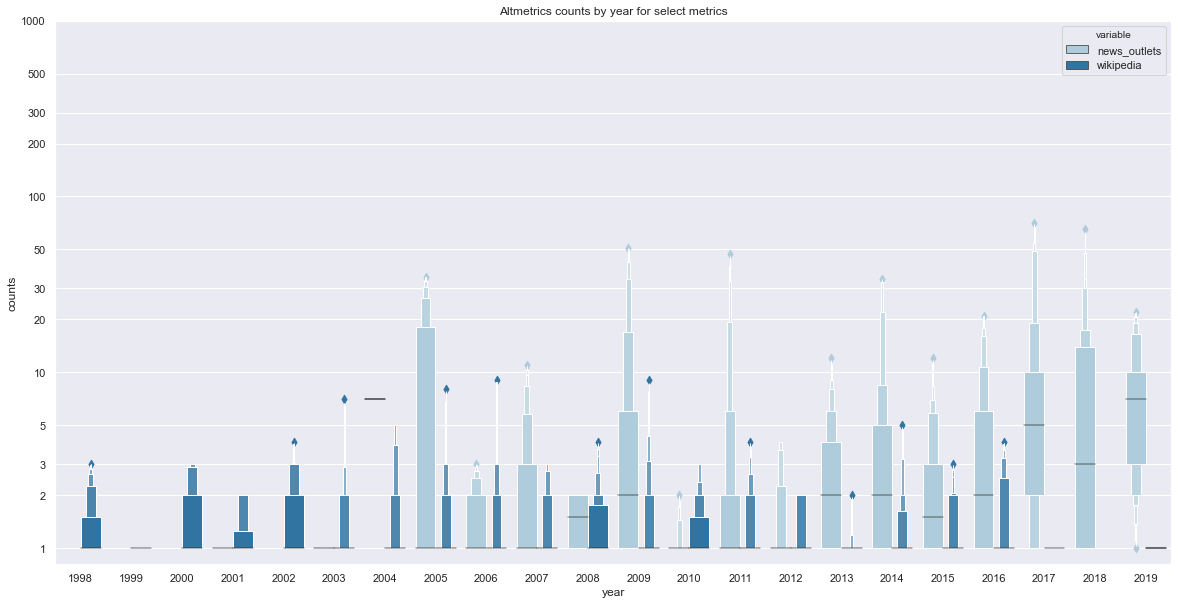

In [28]:
plt_metrics = ['news_outlets', 'wikipedia']
pdf = altmetrics.melt(id_vars="year", value_vars=plt_metrics, value_name="counts")
pdf = pdf[pdf.year.astype(float)>1996]
pdf = pdf.dropna()

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.boxenplot(x="year", y="counts", hue="variable", data=pdf, ax=ax, palette="Paired")
plt.yscale("log")
ticks = [1,2,3,5,10,20,30,50,100,200,300,500,1000]
plt.yticks(ticks, ticks);
plt.title("Altmetrics counts by year for select metrics");

#### By Research Programs

In [33]:
articles

,article_id,reference,score,type,n_grants,pmid
DOI,,,,,,
10.1016/j.nbd.2007.07.015,0,"Zeng L, Ouyand Y, Vered G, et al. 2007. Abnorm...",0.778081,TSCRP,1,17714952.0
10.1212/01.wnl.0000158653.81008.49,1,"Ess KC, Kamp KA, Tu BP, et al. 2005. Developme...",0.850938,TSCRP,1,15851742.0
10.1128/mcb.25.8.3151-3162.2005,2,"Scheidenheim DK, Cresswell J, Haipek CA, et al...",0.823528,TSCRP,1,15798201.0
10.1111/j.1528-1167.2005.00289.x,3,"Jansen LA, Uhlmann EJ, Crino PB, et al. 2005. ...",0.862500,TSCRP,1,16393152.0
10.1002/glia.10324,4,"Ess KC, Uhlmann EJ, Li W, et al. 2004. Express...",0.842993,TSCRP,1,14999811.0
...,...,...,...,...,...,...
10.1089/wound.2016.0719,6706,"Wernke MM, Schroeder RM, Haynes ML, et al. 201...",0.940309,PRORP,1,28736683.0
10.1089/wound.2017.0737,6707,"Rink CL, Wernke MM, Powell HM, et al. 2017. St...",0.932610,PRORP,1,28736682.0
10.1115/1.4039342,6708,"Prost V, Olesnavage KM, Johnson WB, et al. 201...",0.790023,PRORP,1,NaN


In [55]:
df = refs.groupby("type").size().to_frame("total references")
df['found in crossref'] = articles.groupby("type").size()
df["%"] = 100 * articles.groupby("type").size() / refs.groupby("type").size()
df.sort_values("total references")

,total references,found in crossref,%
type,,,
NFRP,208,NaN,NaN
TSCRP,208,197.0,94.711538
PRORP,354,270.0,76.271186
PCRP,8308,6244.0,75.156476


,article_id,reference,score,type,n_grants,pmid
DOI,,,,,,
10.1016/j.nbd.2007.07.015,0,"Zeng L, Ouyand Y, Vered G, et al. 2007. Abnorm...",0.778081,TSCRP,1,17714952.0
10.1212/01.wnl.0000158653.81008.49,1,"Ess KC, Kamp KA, Tu BP, et al. 2005. Developme...",0.850938,TSCRP,1,15851742.0
10.1128/mcb.25.8.3151-3162.2005,2,"Scheidenheim DK, Cresswell J, Haipek CA, et al...",0.823528,TSCRP,1,15798201.0
10.1111/j.1528-1167.2005.00289.x,3,"Jansen LA, Uhlmann EJ, Crino PB, et al. 2005. ...",0.862500,TSCRP,1,16393152.0
10.1002/glia.10324,4,"Ess KC, Uhlmann EJ, Li W, et al. 2004. Express...",0.842993,TSCRP,1,14999811.0
...,...,...,...,...,...,...
10.1089/wound.2016.0719,6706,"Wernke MM, Schroeder RM, Haynes ML, et al. 201...",0.940309,PRORP,1,28736683.0
10.1089/wound.2017.0737,6707,"Rink CL, Wernke MM, Powell HM, et al. 2017. St...",0.932610,PRORP,1,28736682.0
10.1115/1.4039342,6708,"Prost V, Olesnavage KM, Johnson WB, et al. 201...",0.790023,PRORP,1,NaN


In [85]:
df = refs[['grant_id', 'reference']].drop_duplicates().merge(articles.reset_index()[['DOI', 'reference']], left_on="reference", right_on="reference")
df = df.merge(metrics, left_on="DOI", right_index=True)

In [93]:
df[df.grant_id=="PC073470"]

,grant_id,reference,DOI,posts_count,research_highlight,twitter_accounts,patents,news_outlets,blogs,fb_pages,...,peer_reviews,weibo,gplus,reddit_threads,policies,syllabi,linkedin,wikipedia,citations,citation_score
3593,PC073470,"Taylor, et al. 2010. Integrative genomic profi...",10.1016/j.ccr.2010.05.026,15.0,NaN,4.0,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1693.0,48.562


In [96]:
df.groupby("grant_id")['citations'].size().sort_values()

grant_id
MP980015        1
PC074317P1      1
PC080024        1
PC080174        1
PC080176        1
             ... 
PC100473       41
PC010267       51
PC081610       70
PC051369       81
PC021004      119
Name: citations, Length: 2064, dtype: int64

In [94]:
df.groupby("grant_id")['posts_count'].mean().dropna().sort_values()

grant_id
PC011015      1.0
PC020718      1.0
PC121517      1.0
PC020638      1.0
PC020630      1.0
            ...  
PC150704    183.5
PC160986    186.0
PC150144    192.0
TS110056    272.0
PC030943    761.0
Name: posts_count, Length: 1552, dtype: float64

In [69]:
for program in ["TSCRP", "PRORP", "PCRP"]:
    df = metrics.loc[articles[articles.type==program].index]
    prignt(f"{program} (n={len(df)})")
    print(f"\tw citations: {100*df.citations.count() / len(df):.2f}%")
    print(f"\tw altmtrics: {100*df.posts_count.count() / len(df):.2f}%")
    print("")

TSCRP (n=197)
	w citations: 66.50%
	w altmtrics: 59.39%

PRORP (n=270)
	w citations: 72.22%
	w altmtrics: 56.30%

PCRP (n=6244)
	w citations: 36.58%
	w altmtrics: 49.70%



In [75]:
wos.journal.value_counts()

CANCER RESEARCH                                          121
PROSTATE                                                 113
PLOS ONE                                                 105
CLINICAL CANCER RESEARCH                                  84
JOURNAL OF BIOLOGICAL CHEMISTRY                           71
                                                        ... 
JOURNAL OF BIOMATERIALS AND TISSUE ENGINEERING             1
OTOLOGY & NEUROTOLOGY                                      1
VIRCHOWS ARCHIV-AN INTERNATIONAL JOURNAL OF PATHOLOGY      1
CHEMISTRY-A EUROPEAN JOURNAL                               1
MICROFLUIDICS AND NANOFLUIDICS                             1
Name: journal, Length: 627, dtype: int64

## To-Do

New data to get

- Get Metadata from Crossref
- Get OA status from unpaywall
- clinicaltrials.gov

Available data from DoD

- Patents
- Drugs to market

Notes

- Do analysis for 

For grants

- award size
- and some measures

Next Thing To Do:
- Get some plots going to present the gist of this